# 8 - Os peixes-bois condicionais

In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### R Code 8.1

In [5]:
df = pd.read_csv('./data/rugged.csv', sep=';')
df.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


In [6]:
df['log_gdp'] = np.log(df['rgdppc_2000'])  # Log version of outcome
df[['rgdppc_2000', 'log_gdp']].head()

,rgdppc_2000,log_gdp
0,NaN,NaN
1,NaN,NaN
2,1794.729,7.492609
3,NaN,NaN
4,3703.113,8.216929


In [7]:
ddf = df[~np.isnan(df['log_gdp'].values)].copy()

ddf['log_gdp_std'] = ddf['log_gdp'] / np.mean(ddf['log_gdp'])
ddf['rugged_std'] = ddf['rugged'] / np.max(ddf['rugged'])

ddf[['log_gdp_std', 'rugged_std']]

,log_gdp_std,rugged_std
2,0.879712,0.138342
4,0.964755,0.552564
7,1.166270,0.123992
8,1.104485,0.124960
9,0.914904,0.433409
...,...,...
229,0.996681,0.270397
230,0.783032,0.374557
231,1.074365,0.283941
232,0.780967,0.085940


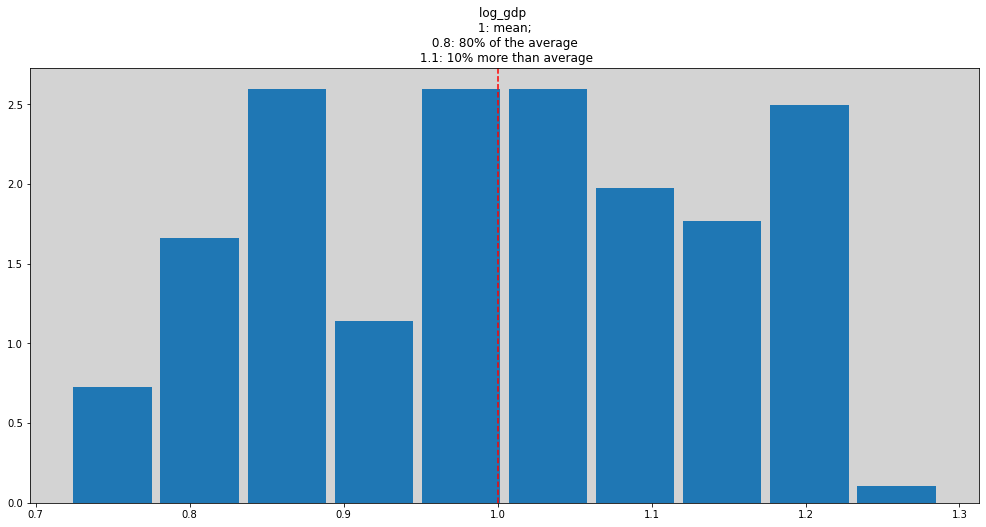

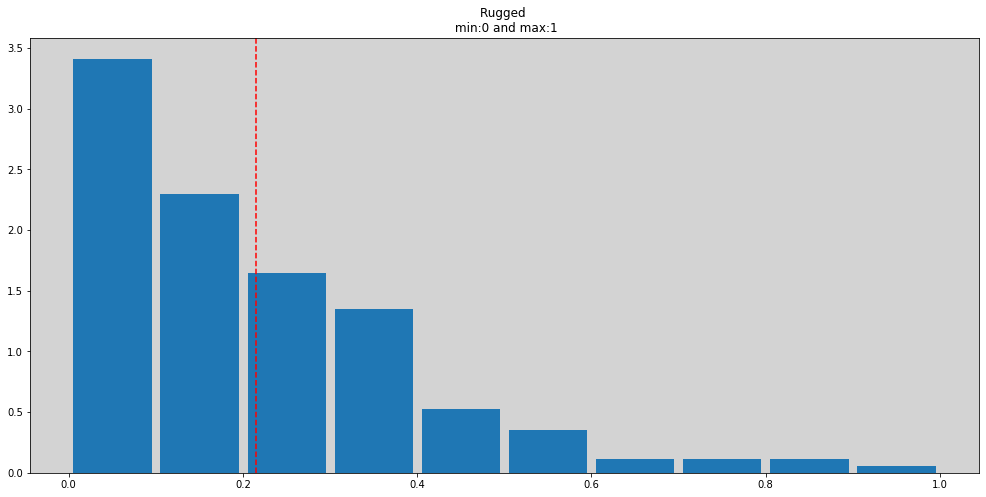

In [8]:
plt.figure(figsize=(17, 8))

plt.hist(ddf['log_gdp_std'], density=True, rwidth=0.9)
plt.title('log_gdp \n 1: mean; \n 0.8: 80% of the average \n 1.1: 10% more than average')
plt.axvline(x=1, c='r', ls='--')
plt.show()

plt.figure(figsize=(17, 8))
plt.hist(ddf['rugged_std'], density=True, rwidth=0.9)
plt.title('Rugged \n min:0 and max:1')
plt.axvline(x=np.mean(ddf['rugged_std']), c='r', ls='--')
plt.show()

### R Code 8.2

In [9]:
model = """
    data {
        int N;
        vector[N] log_gdp_std;
        vector[N] rugged_std;
        real rugged_std_average;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta * (rugged_std - rugged_std_average);
    }
    
    model {
        // Prioris
        
        alpha ~ normal(1, 1);
        beta ~ normal(0, 1);
        sigma ~ exponential(1);
        
        // Likelihood
        log_gdp_std ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;  // By default, if a variable log_lik is present in the Stan model, it will be retrieved as pointwise log likelihood values.
        vector[N] log_gdp_std_hat;
        
        for(i in 1:N){
            log_lik[i] = normal_lpdf(log_gdp_std[i] | mu[i], sigma);
            log_gdp_std_hat[i] = normal_rng(mu[i], sigma);
        }
    }
"""

data = {
    'N': len(ddf),
    'log_gdp_std': ddf['log_gdp_std'].values,
    'rugged_std': ddf['rugged_std'].values,
    'rugged_std_average': ddf['rugged_std'].mean(),
}

posteriori = stan.build(model, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 7.3e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 7e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.


  Adjust your expectations accordingly!


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_5ac987qh/model_tsiivt35.stan', line 29, column 8 to column 40)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Gradient evaluation took 7e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.


  Adjust your expectations accordingly!


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_5ac987qh/model_tsiivt35.stan', line 29, column 8 to column 40)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Gradient evaluation took 7.8e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.


  Adjust your expectations accordingly!


In [10]:
# Transform to dataframe pandas
df_samples = samples.to_frame()
df_samples.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,log_gdp_std_hat.161,log_gdp_std_hat.162,log_gdp_std_hat.163,log_gdp_std_hat.164,log_gdp_std_hat.165,log_gdp_std_hat.166,log_gdp_std_hat.167,log_gdp_std_hat.168,log_gdp_std_hat.169,log_gdp_std_hat.170
draws,,,,,,,,,,,,,,,,,,,,,
0,251.095956,0.934916,0.756421,2.0,3.0,0.0,-249.133644,1.003160,0.012665,0.132500,...,1.034012,0.906565,0.989983,0.945965,1.046566,1.012428,0.871437,0.955593,1.041951,0.856201
1,247.262579,0.989367,0.751819,2.0,3.0,0.0,-246.744846,1.005781,0.135747,0.151454,...,1.044460,1.144566,0.875533,0.860964,1.094581,1.177379,1.083208,1.013122,0.992572,1.167171
2,250.380368,0.998516,0.943934,2.0,7.0,0.0,-249.945732,1.002515,0.032714,0.128198,...,1.047150,1.007480,1.019530,1.052204,1.112828,1.149602,1.175402,1.279579,1.000648,0.870344
3,250.516786,0.913792,0.862509,2.0,3.0,0.0,-249.646704,1.002620,0.045010,0.130002,...,1.144794,0.994287,1.006064,1.133213,0.878218,1.246487,0.956800,0.669329,1.084075,0.973772
4,247.927975,0.574694,0.756421,2.0,3.0,0.0,-246.256142,1.018086,-0.077998,0.129151,...,0.921305,0.814742,0.918643,0.982626,0.949444,0.886278,1.159055,0.902815,0.837451,1.115775


In [11]:
# stan_fit to arviz_stan

stan_data = az.from_pystan(
    posterior=samples,
    posterior_predictive="log_gdp_std_hat",
    observed_data=['log_gdp_std'],
    prior=samples,
    prior_model=posteriori,
    posterior_model=posteriori,
)

In [12]:
stan_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> sample_stats_prior
	> observed_data

In [13]:
az.summary(stan_data, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.000,0.010,0.980,1.019,0.000,0.000,4227.0,2654.0,1.0
beta,0.002,0.056,-0.097,0.113,0.001,0.001,3467.0,2810.0,1.0
sigma,0.138,0.008,0.125,0.153,0.000,0.000,3838.0,2808.0,1.0


### R Code 8.3

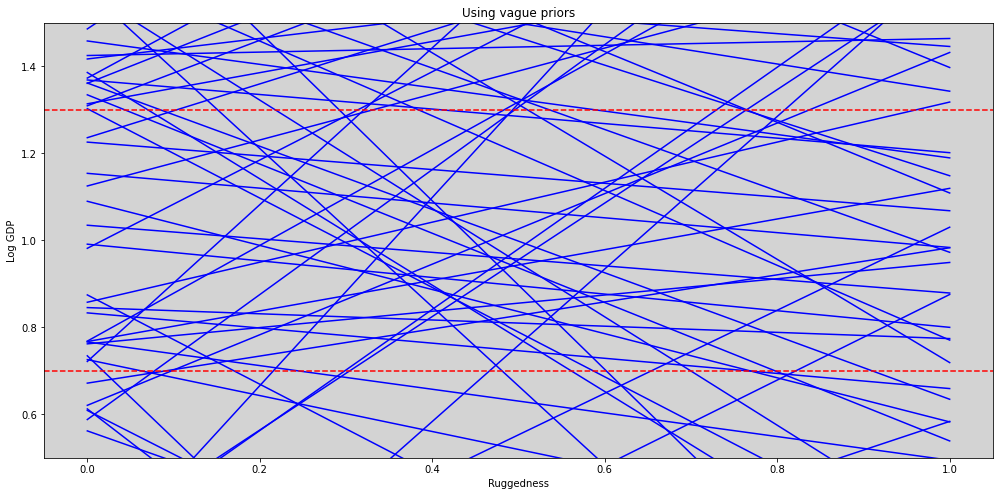

In [14]:
plt.figure(figsize=(17, 8))

alpha = np.random.normal(1, 1, 1000)
beta = np.random.normal(0, 1, 1000)

rugged_seq = np.linspace(0, 1, 100)

for i in range(100):
    plt.plot(rugged_seq, alpha[i] + beta[i] * rugged_seq, c='blue')
    
plt.axhline(y=1.3, c='r', ls='--')    
plt.axhline(y=0.7, c='r', ls='--')    
    
plt.ylim((0.5, 1.5))
plt.title('Using vague priors')
plt.xlabel('Ruggedness')
plt.ylabel('Log GDP')

plt.show()

### R Code 8.4

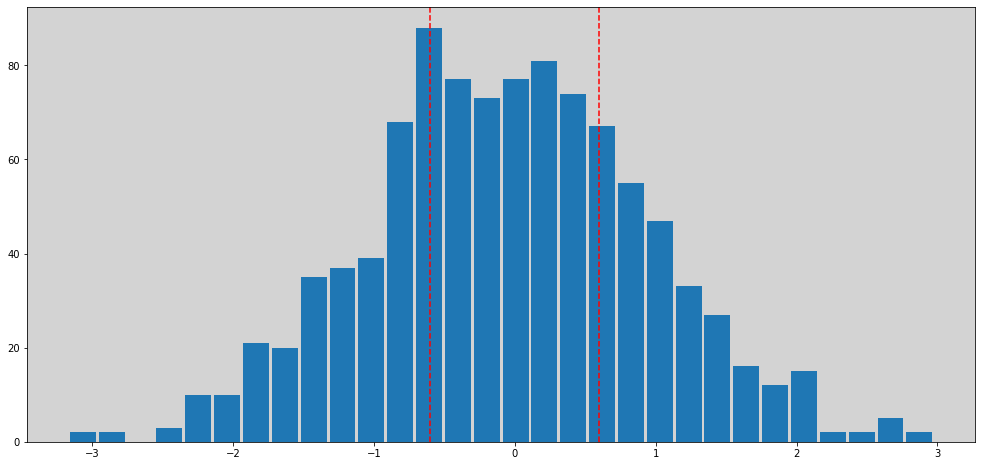

In [15]:
plt.figure(figsize=(17, 8))

plt.hist(beta, bins=30, rwidth=0.9)
plt.axvline(x=0.6, c='r', ls='--')
plt.axvline(x=-0.6, c='r', ls='--')
plt.show()

In [16]:
np.sum(np.sum(np.abs(beta) > 0.6) / len(beta))

0.55

### R Code 8.5

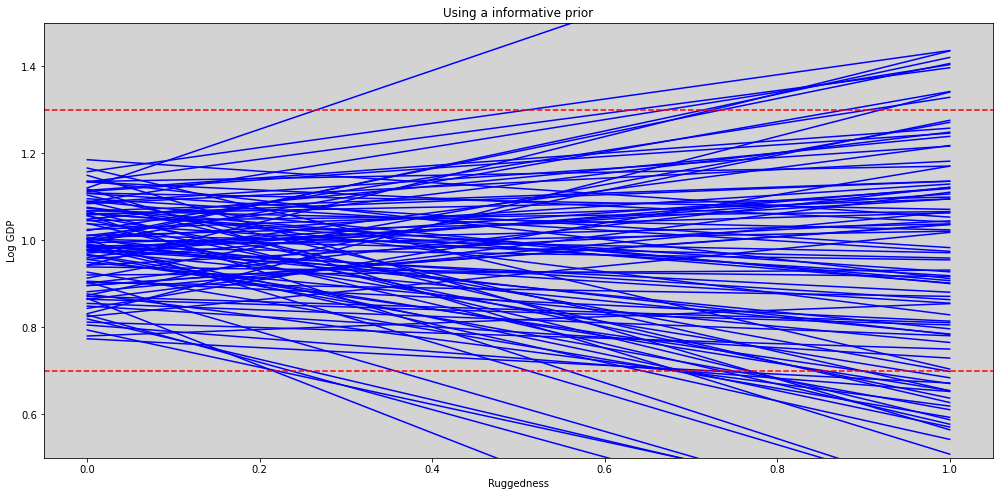

In [17]:
plt.figure(figsize=(17, 8))

alpha = np.random.normal(1, 0.1, 1000)
beta = np.random.normal(0, 0.3, 1000)

rugged_seq = np.linspace(0, 1, 100)

for i in range(100):
    plt.plot(rugged_seq, alpha[i] + beta[i] * rugged_seq, c='blue')
    
plt.axhline(y=1.3, c='r', ls='--')    
plt.axhline(y=0.7, c='r', ls='--')    

plt.ylim((0.5, 1.5))
plt.title('Using a informative prior')
plt.xlabel('Ruggedness')
plt.ylabel('Log GDP')

plt.show()

In [18]:
model2 = """
    data {
        int N;
        vector[N] log_gdp_std;
        vector[N] rugged_std;
        real rugged_std_average;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta * (rugged_std - rugged_std_average);
    
    }
    
    model {
        // Prioris
        
        alpha ~ normal(1, 0.1);
        beta ~ normal(0, 0.3);
        sigma ~ exponential(1);
        
        // Likelihood
        log_gdp_std ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;  // By default, if a variable log_lik is present in the Stan model, it will be retrieved as pointwise log likelihood values.
        vector[N] log_gdp_std_hat;
        
        for(i in 1:N){
            log_lik[i] = normal_lpdf(log_gdp_std[i] | mu[i], sigma);
            log_gdp_std_hat[i] = normal_rng(mu[i], sigma);
        }
    }
"""

data = {
    'N': len(ddf),
    'log_gdp_std': ddf['log_gdp_std'].values,
    'rugged_std': ddf['rugged_std'].values,
    'rugged_std_average': ddf['rugged_std'].mean(),
}

posteriori = stan.build(model2, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.


Sampling:   0%


Sampling:  25% (2000/8000)


Sampling:  50% (4000/8000)


Sampling:  75% (6000/8000)


Sampling: 100% (8000/8000)


Sampling: 100% (8000/8000), done.


Messages received during sampling:


  Gradient evaluation took 6.2e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.


  Adjust your expectations accordingly!


  Gradient evaluation took 3.3e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.


  Adjust your expectations accordingly!


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_dntadgdr/model_fdh32igv.stan', line 30, column 8 to column 40)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Gradient evaluation took 3.1e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.


  Adjust your expectations accordingly!


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_dntadgdr/model_fdh32igv.stan', line 30, column 8 to column 40)


  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


  Gradient evaluation took 4.6e-05 seconds


  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.


  Adjust your expectations accordingly!


In [19]:
stan_data2 = az.from_pystan(
    posterior=samples,
    posterior_predictive="log_gdp_std_hat",
    observed_data=['log_gdp_std'],
    prior=samples,
    prior_model=posteriori,
    posterior_model=posteriori,
)

In [20]:
az.summary(stan_data, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.000,0.010,0.980,1.019,0.000,0.000,4227.0,2654.0,1.0
beta,0.002,0.056,-0.097,0.113,0.001,0.001,3467.0,2810.0,1.0
sigma,0.138,0.008,0.125,0.153,0.000,0.000,3838.0,2808.0,1.0


### R Code 8.7

In [21]:
ddf['cid'] = [1 if cont_africa == 1 else 2 for cont_africa in ddf['cont_africa']]
ddf[['cont_africa', 'cid']].head()

,cont_africa,cid
2,1,1
4,0,2
7,0,2
8,0,2
9,0,2


### R Code 8.8

In [22]:
model3 = """
    data {
        int N;
        vector[N] log_gdp_std;
        vector[N] rugged_std;
        array[N] int cid;  // Must be integer because this is index to alpha.
        real rugged_std_average;
    }
    
    parameters {
        real alpha[2];  //Can be used to real alpha[2] or array[2] int alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        for (i in 1:N){
            mu[i] = alpha[ cid[i] ] + beta * (rugged_std[i] - rugged_std_average);
        }
    }
    
    model {
        // Prioris
        
        alpha ~ normal(1, 0.1);
        beta ~ normal(0, 0.3);
        sigma ~ exponential(1);
        
        // Likelihood
        log_gdp_std ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;
        vector[N] log_gdp_std_hat;
        
        for(i in 1:N){
            log_lik[i] = normal_lpdf(log_gdp_std[i] | mu[i], sigma);
            log_gdp_std_hat[i] = normal_rng(mu[i], sigma);
        }
    }
"""

data = {
    'N': len(ddf),
    'log_gdp_std': ddf['log_gdp_std'].values,
    'rugged_std': ddf['rugged_std'].values,
    'rugged_std_average': ddf['rugged_std'].mean(),
    'cid': ddf['cid'].values,
}

posteriori = stan.build(model3, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.2s


Building: 0.3s


Building: 0.4s


Building: 0.5s


Building: 0.6s


Building: 0.7s


Building: 0.8s


Building: 0.9s


Building: 1.0s


Building: 1.1s


Building: 1.2s


Building: 1.3s


Building: 1.4s


Building: 1.5s


Building: 1.6s


Building: 1.7s


Building: 1.8s


Building: 1.9s


Building: 2.0s


Building: 2.1s


Building: 2.2s


Building: 2.3s


Building: 2.4s


Building: 2.5s


Building: 2.6s


Building: 2.8s


Building: 2.9s


Building: 3.0s


Building: 3.1s


Building: 3.2s


Building: 3.3s


Building: 3.4s


Building: 3.5s


Building: 3.6s


Building: 3.7s


Building: 3.8s


Building: 3.9s


Building: 4.0s


Building: 4.1s


Building: 4.2s


Building: 4.3s


Building: 4.4s


Building: 4.5s


Building: 4.6s


Building: 4.7s


Building: 4.8s


Building: 4.9s


Building: 5.0s


Building: 5.1s


Building: 5.2s


Building: 5.3s


Building: 5.4s


Building: 5.5s


Building: 5.6s


Building: 5.7s


Building: 5.9s


Building: 6.0s


Building: 6.1s


Building: 6.2s


Building: 6.3s


Building: 6.4s


Building: 6.5s


Building: 6.6s


Building: 6.7s


Building: 6.8s


Building: 6.9s


Building: 7.0s


Building: 7.1s


Building: 7.2s


Building: 7.3s


Building: 7.4s


Building: 7.5s


Building: 7.6s


Building: 7.7s


Building: 7.8s


Building: 7.9s


Building: 8.0s


Building: 8.1s


Building: 8.2s


Building: 8.3s


Building: 8.4s


Building: 8.5s


Building: 8.6s


Building: 8.7s


Building: 8.8s


Building: 8.9s


Building: 9.1s


Building: 9.2s


Building: 9.3s


Building: 9.4s


Building: 9.5s


Building: 9.6s


Building: 9.7s


Building: 9.8s


Building: 9.9s


Building: 10.0s


Building: 10.1s


Building: 10.2s


Building: 10.3s


Building: 10.4s


Building: 10.5s


Building: 10.6s


Building: 10.7s


Building: 10.8s


Building: 10.9s


Building: 11.0s


Building: 11.1s


Building: 11.2s


Building: 11.3s


Building: 11.4s


Building: 11.5s


Building: 11.6s


Building: 11.7s


Building: 11.8s


Building: 11.9s


Building: 12.0s


Building: 12.1s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.10.1/m

Building: 12.3s


Building: 12.4s


Building: 12.5s


Building: 12.6s


Building: 12.7s


/home/rodolpho/.cache/httpstan/4.10.1/models/ykwl7v2z/model_ykwl7v2z.cpp: In instantiation of ‘void model_ykwl7v2z_namespace::model_ykwl7v2z::transform_inits_impl(const stan::io::var_context&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_t<T_y>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/ykwl7v2z/model_ykwl7v2z.cpp:543:50:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/ykwl7v2z/model_ykwl7v2z.cpp:368:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  368 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/ykwl7v2z/model_ykwl7v2z.cpp: In instantiation of ‘void model_ykwl7v2z_namespace::model_ykwl7v2z::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI =

Building: 12.8s


Building: 12.9s


Building: 13.0s


Building: 13.1s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T

Building: 13.2s


Building: 13.3s


Building: 13.4s


Building: 13.5s


Building: 13.6s


Building: 13.7s


Building: 13.8s


Building: 13.9s


Building: 14.0s


Building: 14.1s


Building: 14.2s


Building: 14.3s


Building: 14.4s


Building: 14.5s


Building: 14.6s


Building: 14.7s


Building: 14.8s


Building: 14.9s


Building: 15.0s


Building: 15.1s


Building: 15.2s


Building: 15.3s


Building: 15.5s


Building: 15.6s


Building: 15.7s


Building: 15.8s


Building: 15.9s


Building: 16.0s


Building: 16.1s


Building: 16.2s


Building: 16.3s


Building: 16.4s


Building: 16.5s


Building: 16.6s


Building: 16.7s


Building: 16.8s


Building: 16.9s


Building: 17.0s


Building: 17.1s


Building: 17.2s


Building: 17.3s


Building: 17.4s


Building: 17.5s


Building: 17.6s


Building: 17.7s


Building: 17.8s


Building: 17.9s


Building: 18.0s


Building: 18.1s


Building: 18.2s


Building: 18.3s


Building: 18.4s


Building: 18.5s


Building: 18.7s


Building: 18.8s


Building: 18.9s


Building: 19.0s


Building: 19.1s


Building: 19.2s


Building: 19.3s


Building: 19.4s


Building: 19.5s


Building: 19.6s


Building: 19.7s


Building: 19.8s


Building: 19.9s


Building: 20.0s


Building: 20.1s


Building: 20.2s


Building: 20.3s


Building: 20.4s


Building: 20.5s


Building: 20.6s


Building: 20.7s


Building: 20.8s


Building: 20.9s


Building: 21.0s


Building: 21.1s


Building: 21.2s


Building: 21.3s


Building: 21.4s


Building: 21.5s


Building: 21.6s


Building: 21.7s


Building: 21.8s


Building: 22.0s


Building: 22.1s


Building: 22.2s


Building: 22.3s


Building: 22.4s


Building: 22.5s


Building: 22.6s


Building: 22.7s


Building: 22.8s


Building: 22.9s


Building: 23.0s


Building: 23.1s


Building: 23.2s


Building: 23.3s


Building: 23.4s


Building: 23.5s


Building: 23.6s


Building: 23.7s


Building: 23.8s


Building: 23.9s


Building: 24.0s


Building: 24.1s


Building: 24.2s


Building: 24.3s


Building: 24.4s


Building: 24.5s


Building: 24.6s


Building: 24.7s


Building: 24.8s


Building: 24.9s


Building: 25.0s


Building: 25.2s


Building: 25.3s


Building: 25.4s


Building: 25.5s


Building: 25.6s


Building: 25.7s


Building: 25.8s


Building: 25.9s


Building: 26.0s


Building: 26.1s


Building: 26.2s


Building: 26.3s


Building: 26.4s


Building: 26.5s


Building: 26.6s


Building: 26.7s


Building: 26.8s


Building: 26.9s


Building: 27.0s


Building: 27.1s


Building: 27.2s


Building: 27.3s


Building: 27.4s


Building: 27.5s


Building: 27.6s


Building: 27.7s


Building: 27.8s


Building: 27.9s


Building: 28.0s


Building: 28.1s


Building: 28.2s


Building: 28.3s


Building: 28.4s


Building: 28.6s


Building: 28.7s


Building: 28.8s


Building: 28.9s


Building: 29.0s


Building: 29.1s


Building: 29.2s


Building: 29.3s


Building: 29.4s


Building: 29.5s


Building: 29.6s


Building: 29.7s


Building: 29.8s


Building: 29.9s


Building: 30.0s


AttributeError: 'NoneType' object has no attribute 'sample'

In [23]:
stan_data3 = az.from_pystan(
    posterior=samples,
    posterior_predictive="log_gdp_std_hat",
    observed_data=['log_gdp_std'],
    prior=samples,
    prior_model=posteriori,
    posterior_model=posteriori,
    dims={
        "alpha": ["africa"],
    },
)

### R Code 8.9

In [24]:
models_8 = { 'm8.1': stan_data2, 'm8.2': stan_data3 }

az.compare(models_8, ic='waic')

/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m8.2,0,126.166124,4.117261,0.000000,0.969256,7.396644,0.000000,True,log
m8.1,1,94.499399,2.491680,31.666725,0.030744,6.463956,7.317875,False,log


### R Code 8.10

In [25]:
az.summary(stan_data3, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.880,0.016,0.851,0.911,0.000,0.000,4512.0,3483.0,1.0
alpha[1],1.049,0.010,1.031,1.069,0.000,0.000,4305.0,2642.0,1.0
beta,-0.046,0.047,-0.130,0.048,0.001,0.001,3508.0,2517.0,1.0
sigma,0.114,0.006,0.103,0.126,0.000,0.000,3742.0,3076.0,1.0


### R Code 8.11

In [26]:
stan_data3

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> sample_stats_prior
	> observed_data

In [27]:
alpha_a1 = stan_data3.posterior.alpha.sel(africa=0)
alpha_a2 = stan_data3.posterior.alpha.sel(africa=1)

diff_alpha_a1_a2 = az.extract(alpha_a1 - alpha_a2).alpha.values

az.hdi(diff_alpha_a1_a2, hdi_prob=0.89)

array([-0.19925646, -0.13838364])

### R Code 8.12

In [28]:
# Extract 200 samples from arviz-fit to numpy
params_post = az.extract(stan_data3.posterior, num_samples=200)

In [29]:
rugged_seq = np.linspace(0, 1, 30)

log_gdp_mean_africa = []
log_gdp_hdi_africa = []

log_gdp_mean_not_africa = []
log_gdp_hdi_not_africa = []

# Calculation posterior mean and interval HDI
for i in range(len(rugged_seq)):
        log_gdp_africa = params_post.alpha.sel(africa=0) + params_post.beta.values * rugged_seq[i]
        log_gdp_mean_africa.append(np.mean(log_gdp_africa.values))
        log_gdp_hdi_africa.append(az.hdi(log_gdp_africa.values, hdi_prob=0.89))
        
        log_gdp_not_africa = params_post.alpha.sel(africa=1) + params_post.beta.values * rugged_seq[i]
        log_gdp_mean_not_africa.append(np.mean(log_gdp_not_africa.values))
        log_gdp_hdi_not_africa.append(az.hdi(log_gdp_not_africa.values, hdi_prob=0.89))
        
log_gdp_hdi_africa = np.array(log_gdp_hdi_africa)
log_gdp_hdi_not_africa = np.array(log_gdp_hdi_not_africa) 

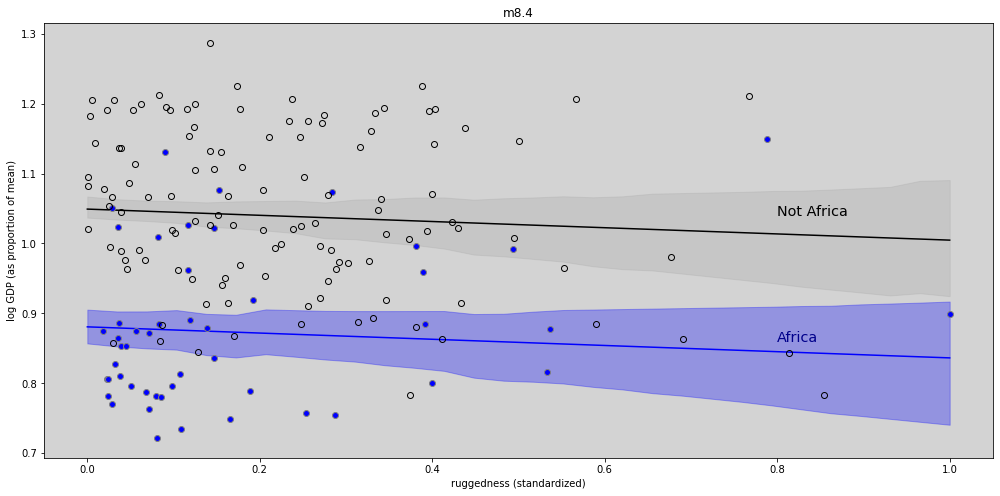

In [30]:
plt.figure(figsize=(17, 8))

plt.plot(rugged_seq, log_gdp_mean_africa, c='blue')
plt.fill_between(rugged_seq, log_gdp_hdi_africa[:,0], log_gdp_hdi_africa[:,1], color='blue', alpha=0.3)

plt.plot(rugged_seq, log_gdp_mean_not_africa, c='black')
plt.fill_between(rugged_seq, log_gdp_hdi_not_africa[:,0], log_gdp_hdi_not_africa[:,1], color='darkgray', alpha=0.3)

plt.plot(ddf.loc[ddf.cid == 1,'rugged_std'], ddf.loc[ddf.cid==1, 'log_gdp_std'], 'o', markerfacecolor='blue', color='gray')
plt.plot(ddf.loc[ddf.cid == 2,'rugged_std'], ddf.loc[ddf.cid==2, 'log_gdp_std'], 'o', markerfacecolor='none', color='black')

plt.title('m8.4')
plt.xlabel('ruggedness (standardized)')
plt.ylabel('log GDP (as proportion of mean)')

plt.text(0.8, 1.04, 'Not Africa', fontsize='x-large', color='black')
plt.text(0.8, 0.86, 'Africa',  fontsize='x-large', color='darkblue')

plt.show()

### R Code 8.13

In [31]:
model4 = """
    data {
        int N;
        vector[N] log_gdp_std;
        vector[N] rugged_std;
        array[N] int cid;  // Must be integer because this is index to alpha.
        real rugged_std_average;
    }
    
    parameters {
        real alpha[2];  //Can be used to real alpha[2] or array[2] int alpha;
        real beta[2];
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        for (i in 1:N){
            mu[i] = alpha[ cid[i] ] + beta[ cid[i] ] * (rugged_std[i] - rugged_std_average);
        }
    }
    
    model {
        // Prioris
        
        alpha ~ normal(1, 0.1);
        beta ~ normal(0, 0.3);
        sigma ~ exponential(1);
        
        // Likelihood
        log_gdp_std ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;
        vector[N] log_gdp_std_hat;
        
        for(i in 1:N){
            log_lik[i] = normal_lpdf(log_gdp_std[i] | mu[i], sigma);
            log_gdp_std_hat[i] = normal_rng(mu[i], sigma);
        }
    }
"""

data = {
    'N': len(ddf),
    'log_gdp_std': ddf['log_gdp_std'].values,
    'rugged_std': ddf['rugged_std'].values,
    'rugged_std_average': ddf['rugged_std'].mean(),
    'cid': ddf['cid'].values,
}

posteriori = stan.build(model4, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan__g9c_c3n/model_5jmion4o.stan', line 11, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan__g9c_c3n/model_5jmion4o.stan', line 12, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would ta

In [32]:
stan_data4 = az.from_pystan(
    posterior=samples,
    posterior_predictive="log_gdp_std_hat",
    observed_data=['log_gdp_std'],
    prior=samples,
    prior_model=posteriori,
    posterior_model=posteriori,
    dims={
        "alpha": ["africa"],
        "beta": ["africa"],
    },
)

### R Code 8.14

In [33]:
az.summary(stan_data4, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.887,0.016,0.858,0.916,0.000,0.000,5156.0,2914.0,1.0
alpha[1],1.051,0.010,1.033,1.071,0.000,0.000,5063.0,3095.0,1.0
beta[0],0.131,0.075,-0.006,0.270,0.001,0.001,4710.0,3386.0,1.0
beta[1],-0.143,0.056,-0.247,-0.036,0.001,0.001,4727.0,3117.0,1.0
sigma,0.112,0.006,0.100,0.123,0.000,0.000,5069.0,3262.0,1.0


### R Code 8.15

In [34]:
models_8 = { 'm8.1': stan_data2, 'm8.2': stan_data3, 'm8.3': stan_data4 }

# https://python.arviz.org/en/stable/api/generated/arviz.compare.html
# https://rss.onlinelibrary.wiley.com/doi/10.1111/1467-9868.00353
az.compare(models_8, ic='loo')  # loo is same that PSIS

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m8.3,0,129.589277,4.989499,0.000000,0.870793,7.309693,0.000000,False,log
m8.2,1,126.137495,4.145890,3.451783,0.129207,7.405339,3.225278,False,log
m8.1,2,94.492463,2.498616,35.096814,0.000000,6.464447,7.448111,False,log


### R Code 8.16

In [35]:
az.loo(stan_data4, pointwise=True)

Computed from 4000 posterior samples and 170 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   129.59     7.31
p_loo        4.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      169   99.4%
 (0.5, 0.7]   (ok)          1    0.6%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [36]:
stan_data4

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> sample_stats_prior
	> observed_data

### R Code 8.16 - XXX

In [37]:
# az.plot_loo_pit(stan_data4, y='log_gdp_std')

### R Code 8.17

In [38]:
# Extract 200 samples from arviz-fit to numpy
params_post = az.extract(stan_data4.posterior, num_samples=200)

In [39]:
rugged_seq = np.linspace(0, 1, 30)

log_gdp_mean_africa = []
log_gdp_hdi_africa = []

log_gdp_mean_not_africa = []
log_gdp_hdi_not_africa = []

# Calculation posterior mean and interval HDI
for i in range(len(rugged_seq)):
        log_gdp_africa = params_post.alpha.sel(africa=0) + params_post.beta.sel(africa=0).values * rugged_seq[i]
        log_gdp_mean_africa.append(np.mean(log_gdp_africa.values))
        log_gdp_hdi_africa.append(az.hdi(log_gdp_africa.values, hdi_prob=0.89))
        
        log_gdp_not_africa = params_post.alpha.sel(africa=1) + params_post.beta.sel(africa=1).values * rugged_seq[i]
        log_gdp_mean_not_africa.append(np.mean(log_gdp_not_africa.values))
        log_gdp_hdi_not_africa.append(az.hdi(log_gdp_not_africa.values, hdi_prob=0.89))
        
log_gdp_hdi_africa = np.array(log_gdp_hdi_africa)
log_gdp_hdi_not_africa = np.array(log_gdp_hdi_not_africa)

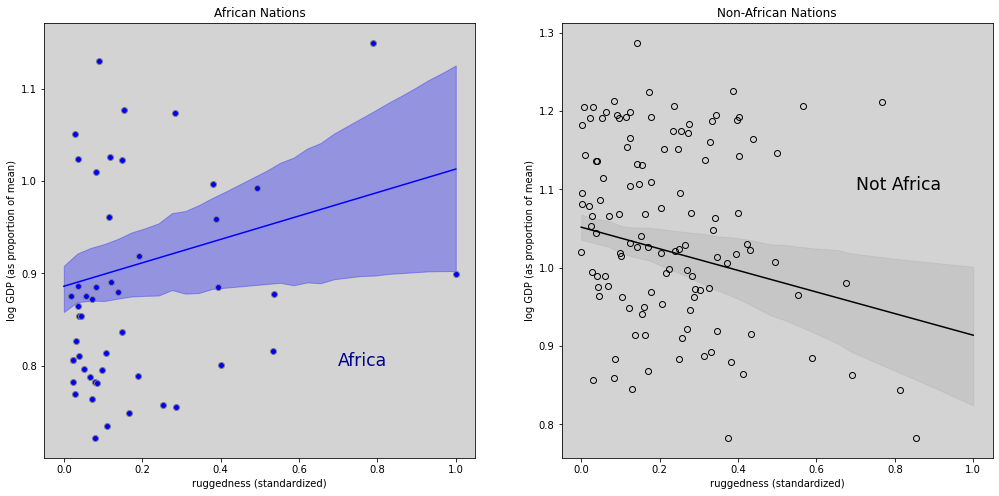

In [40]:
fig = plt.figure(figsize=(17, 8))

gs = GridSpec(1, 2)

# Africa plots
ax_africa = fig.add_subplot(gs[0])

ax_africa.plot(rugged_seq, log_gdp_mean_africa, c='blue')
ax_africa.fill_between(rugged_seq, log_gdp_hdi_africa[:,0], log_gdp_hdi_africa[:,1], color='blue', alpha=0.3)
ax_africa.plot(ddf.loc[ddf.cid == 1,'rugged_std'], ddf.loc[ddf.cid==1, 'log_gdp_std'], 'o', markerfacecolor='blue', color='gray')

ax_africa.set_title('African Nations')
ax_africa.set_xlabel('ruggedness (standardized)')
ax_africa.set_ylabel('log GDP (as proportion of mean)')
ax_africa.text(0.7, 0.8, 'Africa',  fontsize='xx-large', color='darkblue')


# Non africa plots
ax_not_africa = fig.add_subplot(gs[1])

ax_not_africa.plot(rugged_seq, log_gdp_mean_not_africa, c='black')
ax_not_africa.fill_between(rugged_seq, log_gdp_hdi_not_africa[:,0], log_gdp_hdi_not_africa[:,1], color='darkgray', alpha=0.3)
ax_not_africa.plot(ddf.loc[ddf.cid == 2,'rugged_std'], ddf.loc[ddf.cid==2, 'log_gdp_std'], 'o', markerfacecolor='none', color='black')

ax_not_africa.set_title('Non-African Nations')
ax_not_africa.set_xlabel('ruggedness (standardized)')
ax_not_africa.set_ylabel('log GDP (as proportion of mean)')
ax_not_africa.text(0.7, 1.1, 'Not Africa', fontsize='xx-large', color='black')


plt.show()

### R Code 8.18

In [41]:
log_gdp_delta_mean = []
log_gdp_delta_hdi = []

# Calculation posterior mean and interval HDI
for i in range(len(rugged_seq)):
        log_gdp_africa = params_post.alpha.sel(africa=0) + params_post.beta.sel(africa=0).values * rugged_seq[i]
        log_gdp_not_africa = params_post.alpha.sel(africa=1) + params_post.beta.sel(africa=1).values * rugged_seq[i]
        
        log_gdp_delta = log_gdp_africa - log_gdp_not_africa

        log_gdp_delta_mean.append(np.mean(log_gdp_delta.values))
        log_gdp_delta_hdi.append(az.hdi(log_gdp_delta.values, hdi_prob=0.89))
        
log_gdp_delta_hdi = np.array(log_gdp_delta_hdi)

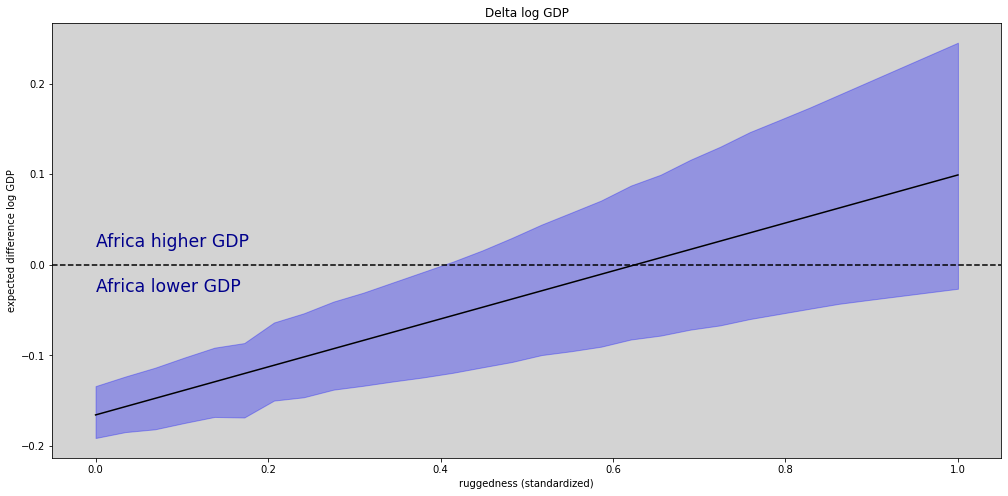

In [42]:
fig = plt.figure(figsize=(17, 8))

gs = GridSpec(1, 1)

# Africa delta log GDP plots
ax_delta = fig.add_subplot(gs[0])

ax_delta.plot(rugged_seq, log_gdp_delta_mean, c='black')
ax_delta.fill_between(rugged_seq, log_gdp_delta_hdi[:,0], log_gdp_delta_hdi[:,1], color='blue', alpha=0.3)

ax_delta.set_title('Delta log GDP')
ax_delta.set_xlabel('ruggedness (standardized)')
ax_delta.set_ylabel('expected difference log GDP')

ax_delta.text(0.0, 0.02, 'Africa higher GDP',  fontsize='xx-large', color='darkblue')
ax_delta.text(0.0, -0.03, 'Africa lower GDP',  fontsize='xx-large', color='darkblue')
ax_delta.axhline(y=0, ls='--', color='black')

plt.show()

### R Code 8.19

In [43]:
df = pd.read_csv('./data/tulips.csv', sep=';',
                 dtype={
                     'bed': 'category',  # cluster of plants from same section of the greenhouse
                     'water': 'float',  # Predictor: Soil moisture - (1) low and (3) high 
                     'shade': 'float',  # Predictor: Light exposure - (1) high and (3) low
                     'blooms': 'float',  # What we wish to predict
                 })
df.tail()

,bed,water,shade,blooms
22,c,2.0,2.0,135.92
23,c,2.0,3.0,90.66
24,c,3.0,1.0,304.52
25,c,3.0,2.0,249.33
26,c,3.0,3.0,134.59


In [44]:
df.describe(include='category')

,bed
count,27
unique,3
top,a
freq,9


In [45]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
water,27.0,2.000000,0.832050,1.0,1.000,2.00,3.0,3.00
shade,27.0,2.000000,0.832050,1.0,1.000,2.00,3.0,3.00
blooms,27.0,128.993704,92.683923,0.0,71.115,111.04,190.3,361.66


### R Code 8.20

In [46]:
df['blooms_std'] = df['blooms'] / df['blooms'].max()
df['water_cent'] = df['water'] - df['water'].mean()
df['shade_cent'] = df['shade'] - df['shade'].mean()

### R Code 8.21

$$ \alpha \sim Normal(0.5, 1) $$

In [47]:
alpha = np.random.normal(0.5, 1, 1000)

alphas_true = np.any([alpha < 0, alpha > 1], axis=0)  # If (alpha < 0) or (alpha > 1) then True else False

np.sum(alphas_true) / len(alpha)

0.628

### R Code 8.22

$$ \alpha \sim Normal(0.5, 0.25) $$

In [48]:
alpha = np.random.normal(0.5, 0.25, 1000)

alphas_true = np.any([alpha < 0, alpha > 1], axis=0)  # If (alpha < 0) or (alpha > 1) then True else False

np.sum(alphas_true) / len(alpha)

0.053

### R Code 8.23

In [49]:
model = """
    data {
        int N;
        vector[N] blooms_std;
        vector[N] water_cent;
        vector[N] shade_cent;
    }
    
    parameters {
        real alpha;
        real beta_w;
        real beta_s;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta_w * water_cent + beta_s * shade_cent;
    }
    
    model {
        // Priori
        
        alpha ~ normal(0.5, 0.25);
        beta_w ~ normal(0, 0.25);
        beta_s ~ normal(0, 0.25);
        sigma ~ exponential(1);
        
        blooms_std ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;
        vector[N] blooms_std_hat;
        
        for(i in 1:N){
            log_lik[i] = normal_lpdf(blooms_std[i] | mu[i], sigma);
            blooms_std_hat[i] = normal_rng(mu[i], sigma);
        }
    }
"""

data = {
    'N': len(df),
    'blooms_std': df.blooms_std.values,   
    'water_cent': df.water_cent.values,
    'shade_cent': df.shade_cent.values,
}

posteriori = stan.build(model, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_v58v6sbi/model_elkgjo5c.stan', line 30, column 8 to column 39)
  If this warning o

In [50]:
stan_blooms = az.from_pystan(
    prior_model=posteriori,
    prior=samples,
    posterior_model=posteriori,
    posterior=samples,
    posterior_predictive="blooms_std_hat",
    observed_data=['blooms_std', 'water_cent', 'shade_cent'],
)

stan_blooms

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> sample_stats_prior
	> observed_data

In [51]:
az.summary(stan_blooms, var_names=['alpha', 'beta_w', 'beta_s'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.359,0.034,0.298,0.429,0.001,0.0,3857.0,2579.0,1.0
beta_w,0.203,0.041,0.126,0.279,0.001,0.0,4353.0,3032.0,1.0
beta_s,-0.112,0.041,-0.188,-0.036,0.001,0.0,4151.0,2524.0,1.0


### R Code 8.24

$$ B_i \sim Normal(\mu_i, \sigma) $$

$$ \mu_i = \alpha + \beta_W W_i + \beta_S S_i + \beta_{WS} S_i W_i $$

In [52]:
model = """
    data {
        int N;
        vector[N] blooms_std;
        vector[N] water_cent;
        vector[N] shade_cent;
    }
    
    parameters {
        real alpha;
        real beta_w;
        real beta_s;
        real beta_ws;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        vector[N] mu;
        
        mu = alpha + beta_w * water_cent + beta_s * shade_cent + beta_ws * water_cent .* shade_cent;
    }
    
    model {
        // Priori
        
        alpha ~ normal(0.5, 0.25);
        beta_w ~ normal(0, 0.25);
        beta_s ~ normal(0, 0.25);
        beta_ws ~ normal(0, 0.25);
        sigma ~ exponential(1);
        
        blooms_std ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[N] log_lik;
        vector[N] blooms_std_hat;
        
        for(i in 1:N){
            log_lik[i] = normal_lpdf(blooms_std[i] | mu[i], sigma);
            blooms_std_hat[i] = normal_rng(mu[i], sigma);
        }
    }
"""

data = {
    'N': len(df),
    'blooms_std': df.blooms_std.values,   
    'water_cent': df.water_cent.values,
    'shade_cent': df.shade_cent.values,
}

posteriori = stan.build(model, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!


In [53]:
stan_blooms_interaction = az.from_pystan(
    prior_model=posteriori,
    prior=samples,
    posterior_model=posteriori,
    posterior=samples,
    posterior_predictive="blooms_std_hat",
    observed_data=['blooms_std', 'water_cent', 'shade_cent'],
)

stan_blooms_interaction

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> sample_stats_prior
	> observed_data

In [54]:
az.summary(stan_blooms_interaction, var_names=['alpha', 'beta_w', 'beta_s', 'beta_ws'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.358,0.029,0.301,0.411,0.000,0.0,5629.0,2730.0,1.0
beta_w,0.206,0.034,0.145,0.275,0.000,0.0,4954.0,2852.0,1.0
beta_s,-0.113,0.034,-0.177,-0.051,0.000,0.0,5101.0,3033.0,1.0
beta_ws,-0.143,0.042,-0.220,-0.059,0.001,0.0,5011.0,3012.0,1.0


### R Code 8.25

In [55]:
blooms_post = az.extract(stan_blooms.posterior, num_samples=20)  # get 20 lines
blooms_post_int = az.extract(stan_blooms_interaction.posterior, num_samples=20)  # get 20 lines

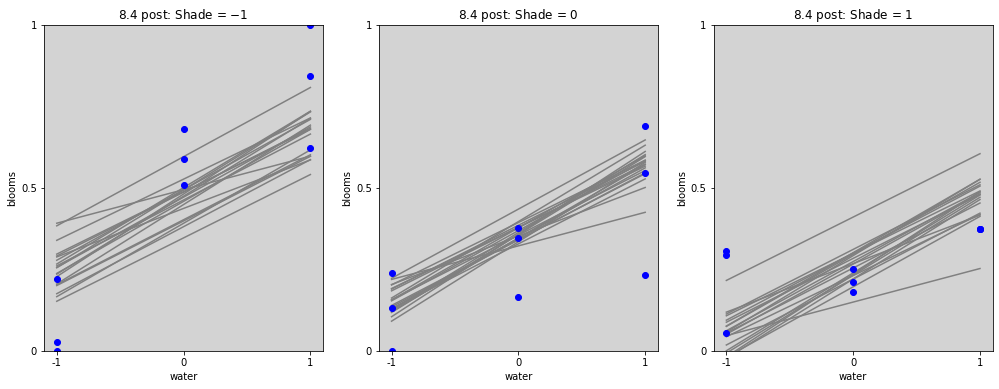

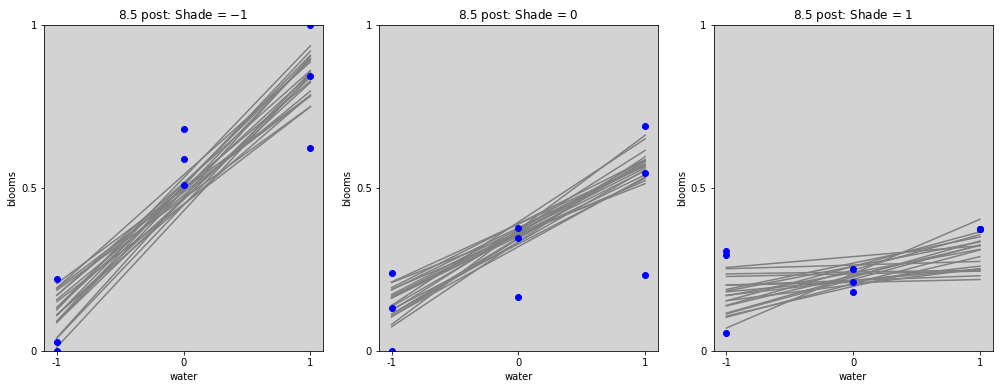

In [56]:
# ================
# Plot without interactions

water_seq = np.linspace(-1, 1, 30)

fig = plt.figure(figsize=(17, 6))

gs = GridSpec(1, 3)

shade_cent_values = [-1, 0, 1]

ax = [None] * len(shade_cent_values)

for j, shade_plot_aux in enumerate(shade_cent_values):
    ax[j] = fig.add_subplot(gs[j])

    for i in range(len(blooms_post.alpha)):
        mu = blooms_post.alpha[i].values + \
             blooms_post.beta_w[i].values * water_seq + \
             blooms_post.beta_s[i].values * (shade_plot_aux)

        ax[j].plot(water_seq, mu, c='gray')
        ax[j].set_ylim(0, 1)
        ax[j].set_title(f'8.4 post: Shade = ${shade_plot_aux}$')
        ax[j].set_xlabel('water')
        ax[j].set_ylabel('blooms')
        ax[j].set_xticks(shade_cent_values, shade_cent_values)
        ax[j].set_yticks([0, 0.5, 1.0], [0, 0.5, 1])

    ax[j].plot(
            df.loc[df['shade_cent'] == shade_plot_aux,'water_cent'].values, 
            df.loc[df['shade_cent'] == shade_plot_aux,'blooms_std'].values, 
            'o', c='blue')
    
plt.show()

# ================
# Plot with interactions

water_seq = np.linspace(-1, 1, 30)

fig = plt.figure(figsize=(17, 6))

gs = GridSpec(1, 3)

shade_cent_values = [-1, 0, 1]

ax = [None] * len(shade_cent_values)

for j, shade_plot_aux in enumerate(shade_cent_values):
    ax[j] = fig.add_subplot(gs[j])

    for i in range(len(blooms_post_int.alpha)):
        mu = blooms_post_int.alpha[i].values + \
             blooms_post_int.beta_w[i].values * water_seq + \
             blooms_post_int.beta_s[i].values * (shade_plot_aux) + \
             blooms_post_int.beta_ws[i].values * water_seq * (shade_plot_aux)

        ax[j].plot(water_seq, mu, c='gray')
        ax[j].set_ylim(0, 1)
        ax[j].set_title(f'8.5 post: Shade = ${shade_plot_aux}$')
        ax[j].set_xlabel('water')
        ax[j].set_ylabel('blooms')
        ax[j].set_xticks(shade_cent_values, shade_cent_values)
        ax[j].set_yticks([0, 0.5, 1.0], [0, 0.5, 1])

    ax[j].plot(
            df.loc[df['shade_cent'] == shade_plot_aux,'water_cent'].values, 
            df.loc[df['shade_cent'] == shade_plot_aux,'blooms_std'].values, 
            'o', c='blue')
    
plt.show()

### R Code 8.26

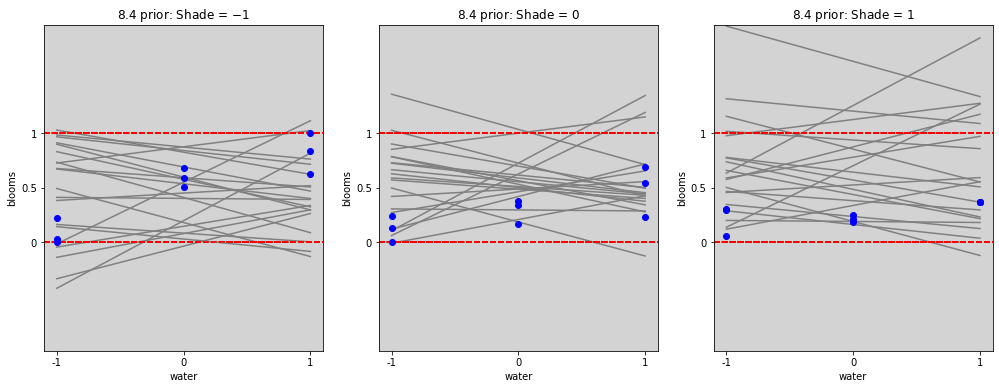

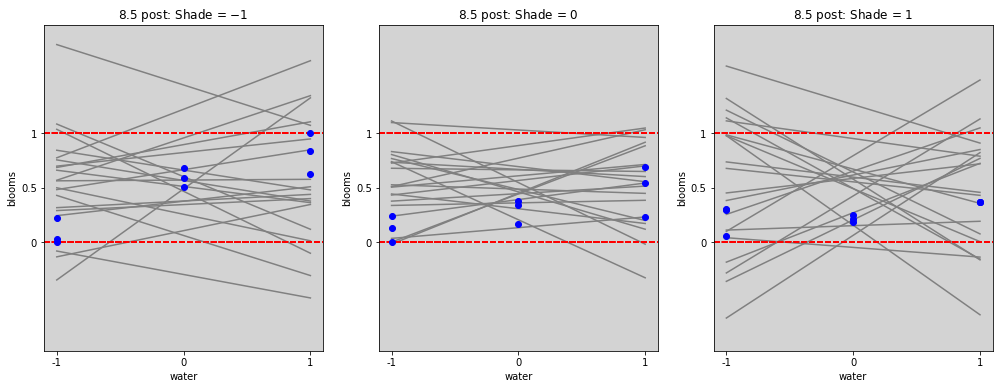

In [57]:
# ================
# Plot without interactions

# Prior
alpha_prior =  np.random.normal(0.5, 0.25, 20)
beta_w_prior =  np.random.normal(0, 0.25, 20)
beta_s_prior =  np.random.normal(0, 0.25, 20)

water_seq = np.linspace(-1, 1, 30)

fig = plt.figure(figsize=(17, 6))

gs = GridSpec(1, 3)

shade_cent_values = [-1, 0, 1]

ax = [None] * len(shade_cent_values)

for j, shade_plot_aux in enumerate(shade_cent_values):
    ax[j] = fig.add_subplot(gs[j])

    for i in range(len(alpha_prior)):
        mu = alpha_prior[i] + \
             beta_w_prior[i] * water_seq + \
             beta_s_prior[i] * (shade_plot_aux)

        ax[j].plot(water_seq, mu, c='gray')
        ax[j].set_ylim(0, 1)
        ax[j].set_title(f'8.4 prior: Shade = ${shade_plot_aux}$')
        ax[j].set_xlabel('water')
        ax[j].set_ylabel('blooms')
        ax[j].set_xticks(shade_cent_values, shade_cent_values)
        ax[j].set_yticks([0, 0.5, 1.0], [0, 0.5, 1])
        ax[j].set_ylim(-1, 2)
        ax[j].axhline(y=1, ls='--', color='red')
        ax[j].axhline(y=0, ls='--', color='red')

    ax[j].plot(
            df.loc[df['shade_cent'] == shade_plot_aux,'water_cent'].values, 
            df.loc[df['shade_cent'] == shade_plot_aux,'blooms_std'].values, 
            'o', c='blue')
    
plt.show()

# ================
# Plot with interactions

# Prior
alpha_prior =  np.random.normal(0.5, 0.25, 20)
beta_w_prior =  np.random.normal(0, 0.25, 20)
beta_s_prior =  np.random.normal(0, 0.25, 20)
beta_ws_prior =  np.random.normal(0, 0.25, 20)

water_seq = np.linspace(-1, 1, 30)

fig = plt.figure(figsize=(17, 6))

gs = GridSpec(1, 3)

shade_cent_values = [-1, 0, 1]

ax = [None] * len(shade_cent_values)

for j, shade_plot_aux in enumerate(shade_cent_values):
    ax[j] = fig.add_subplot(gs[j])

    for i in range(len(alpha_prior)):
        mu = alpha_prior[i] + \
             beta_w_prior[i] * water_seq + \
             beta_s_prior[i] * (shade_plot_aux) + \
             beta_ws_prior[i] * water_seq * (shade_plot_aux)

        ax[j].plot(water_seq, mu, c='gray')
        ax[j].set_ylim(0, 1)
        ax[j].set_title(f'8.5 post: Shade = ${shade_plot_aux}$')
        ax[j].set_xlabel('water')
        ax[j].set_ylabel('blooms')
        ax[j].set_xticks(shade_cent_values, shade_cent_values)
        ax[j].set_yticks([0, 0.5, 1.0], [0, 0.5, 1])
        ax[j].set_ylim(-1, 2)
        ax[j].axhline(y=1, ls='--', color='red')
        ax[j].axhline(y=0, ls='--', color='red')

    ax[j].plot(
            df.loc[df['shade_cent'] == shade_plot_aux,'water_cent'].values, 
            df.loc[df['shade_cent'] == shade_plot_aux,'blooms_std'].values, 
            'o', c='blue')
    
plt.show()